In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib.lines import Line2D

import numpy as np
import scipy

import sklearn.metrics as sm

## Plot comparing closed-set and open-set performance

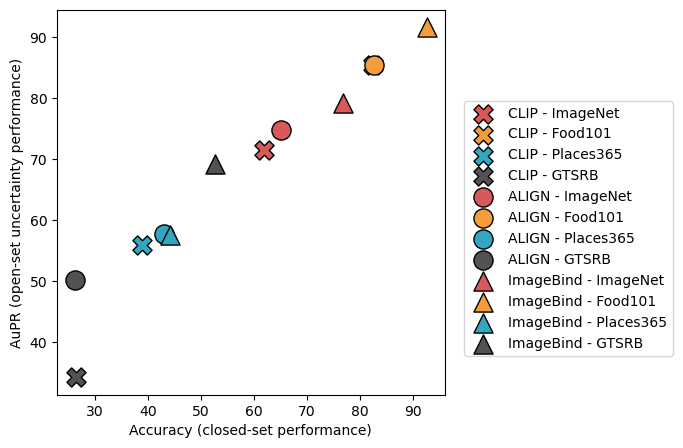

In [2]:
markerTypes = ['X', 'o', '^']
cols = ['#D85959', '#F59D3B', '#32A7BF', '#545154']

modelNames = ['CLIP', 'ALIGN', 'ImageBind']
dataNames = ['ImageNet', 'Food101', 'Places365', 'GTSRB']
data_sizes = {'imagenet': 1000, 'food101': 101, 'places365': 365, 'gtsrb': 43}
fig, ax = plt.subplots(1, figsize = (5, 5))
for mIdx, modelType in enumerate(['clip', 'align', 'imagebind']):
    for dIdx, dataset in enumerate(['imagenet', 'food101', 'places365', 'gtsrb']):
        try:
            gt_labels = np.load(f'../pred_files/{modelType}/{dataset}/standard_gt_{modelType}.npy')
            all_cosine = np.load(f'../pred_files/{modelType}/{dataset}/standard_cosine_{modelType}.npy')
        except:
            print(f'No data for {modelType} {dataset}')
            continue
            
        raw_results = {'softmax': [[], []]}
        num_classes = data_sizes[dataset]
        for idx in range(len(all_cosine)):
            #### Closed-set test
            target = gt_labels[idx]    
            cosine = all_cosine[idx]
    
            softmax = scipy.special.softmax(cosine)
            pred_idx = np.argmax(softmax)
            pred_score = softmax[pred_idx]

            correct = pred_idx == target
        
            if correct: #True positive
                raw_results['softmax'][0] += [pred_score]
        
            #### Open-set test
            known_classes = np.concatenate((np.arange(0, target), np.arange(target+1, len(cosine))))
            cosine_subset = cosine[known_classes]
        
            softmax = scipy.special.softmax(cosine_subset)
            pred_idx = np.argmax(softmax)
            pred_score = softmax[pred_idx]
            
            #Open-set error
            raw_results['softmax'][1] += [pred_score]

        
        for kIdx, k in enumerate(raw_results.keys()):
            tp = raw_results[k][0]
            ose = raw_results[k][1]
    
            acc = len(tp)/len(gt_labels)
            
            true = np.concatenate((np.ones(len(tp)), np.zeros(len(ose))))
            scores = np.concatenate((tp, ose))

            precision, recall, thresholds = sm.precision_recall_curve(true, scores)
            
            aupr = sm.auc(recall, precision)

            ax.scatter(100.*acc, 100.*aupr, marker = markerTypes[mIdx], c = cols[dIdx], alpha = 1, s = 190, edgecolors = 'black', label = f'{modelNames[mIdx]} - {dataNames[dIdx]}')    

ax.set_xlabel('Accuracy (closed-set performance)')
ax.set_ylabel('AuPR (open-set uncertainty performance)')

ax.legend(loc = (1.05, 0.1), ncols = 1)
plt.savefig('../figures/classifier_accvsaupr_alldatasets.pdf', bbox_inches = 'tight')
plt.show()
        